# Data wrangling 

In [1]:
import preprocessing as pre
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from sklearn import metrics
import plotly.express as px
from sklearn import preprocessing

### Data for behavioral and self-report assessment

First let's import the neuro dataset (neuropsychological assessment)

In [2]:
neuro = pd.read_excel("Data/Neuropsy.xlsx", na_values='.').dropna()
neuro['ID']='id_'+neuro['ID'].astype(str)
neuro.rename(columns={'ID':'id'}, inplace=True)# rename ID to id (to match eeg dataset)
neuro['subtype'] = neuro.apply(lambda x: pre.categorize_subtypes(x['inat'], x['hyper']), axis=1)# create a column with categorized subtybes (based on clinical thresholds)
neuro['is_inat'] = neuro['subtype'].apply(lambda x: 0 if x=='hyper' else 1) # create a columns to label prensence of inat and hyper
neuro['is_hyper'] = neuro['subtype'].apply(lambda x: 0 if x=='inat' else 1)
neuro = neuro.rename(columns={"Gender": "Sex"})# so it's more appropriate
neuro.reset_index(drop=True, inplace = True) # reset index as lines were removed with na_drop
neuro

id  Age  Sex   cIM   cHR   cIE   cSC  inat  hyper  Aqtot  Aqaudi  \
0     id_1   21    1  17.0  31.0  29.0   9.0  18.0   20.0   90.0    91.0   
1     id_3   20    1  10.0   5.0  13.0   1.0   8.0    5.0   27.0    34.0   
2     id_4   18    1  26.0  17.0   7.0  15.0  23.0   11.0   93.0    89.0   
3     id_7   23    1  24.0   8.0   6.0  14.0  19.0    3.0   86.0    66.0   
4    id_11   21    1  16.0  26.0  13.0  10.0  17.0   13.0   45.0    33.0   
..     ...  ...  ...   ...   ...   ...   ...   ...    ...    ...     ...   
91  id_602   19    1  25.0  14.0  20.0  18.0  21.0    8.0   80.0    87.0   
92  id_603   19    1  32.0  15.0  14.0  15.0  22.0    9.0  111.0   103.0   
93  id_700   18    2  13.0  33.0  14.0  11.0  18.0   15.0   83.0    80.0   
94  id_701   19    1  22.0  17.0  15.0  12.0  15.0   11.0    0.0    20.0   
95  id_702   18    1  17.0  14.0  10.0   9.0  12.0    3.0   91.0    88.0   

    Aqvis  RCQtot  RCQaudi  RCQvis subtype  is_inat  is_hyper  
0    92.0    94.0     80.0   110.0   mixed        1         1  
1    41.0    25.0     31.0    38.0   mixed        1         1  
2    96.0    90.0     92.0    90.0    inat        1         0  
3   112.0    94.0     90.0   100.0    inat        1         0  
4    78.0    69.0     51.0    94.0   mixed        1         1  
..    ...     ...      ...     ...     ...      ...       ...  
91   77.0    71.0     71.0    79.0    inat        1         0  
92  118.0    63.0     78.0    56.0    inat        1         0  
93   89.0    70.0     72.0    75.0   mixed        1         1  
94    0.0    29.0     32.0    42.0   mixed        1         1  
95   95.0    94.0     87.0   104.0    inat        1         0  

[96 rows x 18 columns]

In [3]:
neuro.Sex.value_counts() #verify sample gender 

1    57
2    39
Name: Sex, dtype: int64

Import all all excel files into one df following function from our .py file

In [4]:
eeg = pre.process_all_excel_files()
eeg['fft_abs_power'] = eeg['fft_abs_power'].astype(float)
eeg['id'] = eeg['id'].astype(int)
eeg['id'] ='id_'+eeg['id'].astype(str)
eeg = eeg[['id', 'brain_oscillation','electrode', 'fft_abs_power']]
print(eeg.shape)
eeg.head(5)

(21109, 4)


id brain_oscillation electrode  fft_abs_power
0  id_134             Delta       FP1      15.565495
1  id_134             Delta       FP2      13.945462
2  id_134             Delta        F7      10.874886
3  id_134             Delta        F3      13.581803
4  id_134             Delta        Fz      15.644595

Selecting brain_oscillations of interest only

In [5]:
eeg = eeg.loc[(eeg['brain_oscillation'] != 'HighBeta') & (eeg['brain_oscillation'] != 'HighGamma') & (eeg['brain_oscillation'] != 'Gamma')]
eeg.brain_oscillation.value_counts()
eeg

id brain_oscillation electrode  fft_abs_power
0      id_134             Delta       FP1      15.565495
1      id_134             Delta       FP2      13.945462
2      id_134             Delta        F7      10.874886
3      id_134             Delta        F3      13.581803
4      id_134             Delta        Fz      15.644595
...       ...               ...       ...            ...
21104   id_87             Beta2        Pz       1.224356
21105   id_87             Beta2        P4       1.139701
21106   id_87             Beta2        T6       1.157928
21107   id_87             Beta2        O1       2.315535
21108   id_87             Beta2        O2       1.199553

[15352 rows x 4 columns]

#### Pool of electrodes for analyses purposes

In [6]:
eeg['electrode_pool'] = eeg['electrode'].apply(lambda x: pre.electrode_pools(x))
eeg = eeg[['id', 'brain_oscillation','electrode_pool', 'electrode', 'fft_abs_power']]
eeg

id brain_oscillation electrode_pool electrode  fft_abs_power
0      id_134             Delta        frontal       FP1      15.565495
1      id_134             Delta        frontal       FP2      13.945462
2      id_134             Delta        frontal        F7      10.874886
3      id_134             Delta        frontal        F3      13.581803
4      id_134             Delta        frontal        Fz      15.644595
...       ...               ...            ...       ...            ...
21104   id_87             Beta2       parietal        Pz       1.224356
21105   id_87             Beta2       parietal        P4       1.139701
21106   id_87             Beta2       temporal        T6       1.157928
21107   id_87             Beta2      occipital        O1       2.315535
21108   id_87             Beta2      occipital        O2       1.199553

[15352 rows x 5 columns]

## Setting up df for analysis

Drop hyper subtype as under represented n=2 on a n=96 sample

In [7]:
neuro.drop(neuro[ neuro['subtype'] == 'hyper' ].index , inplace=True)
neuro.subtype.value_counts()

inat     48
mixed    46
Name: subtype, dtype: int64

Merge dataframes togeter and keep columns of interest

In [8]:
#inner join to keep ids present in both dataframes
df = pd.merge(eeg, neuro[['id', 'Sex','subtype','is_inat','is_hyper', 'inat','hyper']], on='id', how='inner')
# Sort the rows of dataframe by column 'id'
df = df.sort_values(by ='id' )
df_sex = df
print(df.shape)
print(len(df.id.unique()))
df.head()

(14288, 11)
94


id brain_oscillation electrode_pool electrode  fft_abs_power  Sex  \
12691  id_1              Beta      occipital        O2       5.587346    1   
12714  id_1            Alpha2        frontal        F3       1.963479    1   
12715  id_1            Alpha2        frontal        Fz       2.308702    1   
12716  id_1            Alpha2        frontal        F4       2.299275    1   
12717  id_1            Alpha2        frontal        F8       1.498766    1   

      subtype  is_inat  is_hyper  inat  hyper  
12691   mixed        1         1  18.0   20.0  
12714   mixed        1         1  18.0   20.0  
12715   mixed        1         1  18.0   20.0  
12716   mixed        1         1  18.0   20.0  
12717   mixed        1         1  18.0   20.0

Create here the label df because otherwise it gets tricky

## Target df creation 

In [9]:
labels = neuro[['id','subtype']].copy()
labels.set_index('id', inplace=True)
le = preprocessing.LabelEncoder()
labels['subtype'] = le.fit_transform(labels['subtype'])
labels

subtype
id             
id_1          1
id_3          1
id_4          0
id_7          0
id_11         1
...         ...
id_602        0
id_603        0
id_700        1
id_701        1
id_702        0

[94 rows x 1 columns]

In [10]:
hyper_labels = df['is_hyper']
inat_labels = df['is_inat']
sex_labels = df['Sex']

# Descriptive stats

## Descriptive stats table of spectral power by brain oscillation and subtypes

In [11]:
df_desc = df[['subtype','brain_oscillation','electrode_pool','electrode', 'fft_abs_power']]
df_desc.groupby(['brain_oscillation', 'subtype', 'electrode_pool']).describe()

fft_abs_power                        \
                                                 count       mean        std   
brain_oscillation subtype electrode_pool                                       
Alpha             inat    central                144.0  11.715133   9.780271   
                          frontal                336.0   6.060347   4.632657   
                          occipital               96.0  15.450057  17.900577   
                          parietal               144.0  19.149843  21.958774   
                          temporal               192.0   7.822252   8.734088   
...                                                ...        ...        ...   
Theta             mixed   central                138.0  12.514011   8.643829   
                          frontal                322.0   8.867442   5.370949   
                          occipital               92.0   9.689827   6.902123   
                          parietal               138.0  12.962054  10.934348   
                          temporal               184.0   6.703993   5.573898   

                                                                         \
                                               min       25%        50%   
brain_oscillation subtype electrode_pool                                  
Alpha             inat    central         1.640155  3.529081   7.741770   
                          frontal         1.014382  2.672340   4.406889   
                          occipital       1.293514  4.299259   8.516642   
                          parietal        1.519389  4.630020  10.150837   
                          temporal        0.818976  2.450690   4.642972   
...                                            ...       ...        ...   
Theta             mixed   central         3.246318  7.336768  10.589730   
                          frontal         2.064215  5.301798   7.418418   
                          occipital       3.139600  5.531670   7.719703   
                          parietal        3.354802  6.993322   9.602989   
                          temporal        1.539832  3.846603   5.241976   

                                                                 
                                                75%         max  
brain_oscillation subtype electrode_pool                         
Alpha             inat    central         17.806162   39.687264  
                          frontal          8.254827   26.879928  
                          occipital       17.481756  105.947306  
                          parietal        25.171218  105.853186  
                          temporal         9.645865   55.328828  
...                                             ...         ...  
Theta             mixed   central         15.175002   60.046480  
                          frontal         10.975123   41.474438  
                          occipital       10.480402   43.284163  
                          parietal        14.692960   75.112935  
                          temporal         7.615177   47.399760  

[80 rows x 8 columns]

## Some data vizualisation 

### Spectral power within each frequency band, for each electrode for each subtype

In [12]:
graph_data = df.groupby(['electrode','brain_oscillation', 'subtype']).agg({'fft_abs_power':'mean'}).reset_index()
graph_data.sort_values(['brain_oscillation','fft_abs_power'] ,inplace=True)
fig = px.bar(graph_data, x='electrode', y='fft_abs_power', facet_col='brain_oscillation', color='subtype')
fig.show()

### Spectral power within each frequency band, for each electrode_pool by subtype

In [13]:
graph_data = df.groupby(['electrode_pool','brain_oscillation', 'subtype']).agg({'fft_abs_power':'mean'}).reset_index()
graph_data.sort_values(['brain_oscillation','fft_abs_power'] ,inplace=True)
fig = px.bar(graph_data, x='brain_oscillation', y='fft_abs_power', facet_col='electrode_pool', color='subtype')
fig.show()

# PCA and knn by electrode pools using brain oscillation as features

## PCA on electrode pools 

#### Retain one pool at a time

#### PCA targetting prediction of gender by features of electrode, brain oscillation, and scores at inat and hyper

In [14]:
df_agg = df.groupby(['id',"brain_oscillation", 'electrode_pool', 'subtype']).agg({'fft_abs_power': 'mean'}).reset_index()
df_agg.head()

id brain_oscillation electrode_pool subtype  fft_abs_power
0  id_1             Alpha        central   mixed      11.485838
1  id_1             Alpha        frontal   mixed       4.026550
2  id_1             Alpha      occipital   mixed       8.317766
3  id_1             Alpha       parietal   mixed      16.262036
4  id_1             Alpha       temporal   mixed       5.613468

Extract one electrode at a time to run PCA

### PCA on central

In [15]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'central',labels)
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.76205384 0.11492246]


### KNN with these PCAs

Confusion matrix, without normalization
[[8 2]
 [8 1]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.89 0.11]]
Accuracy: 0.47368421052631576
Classification score 0.5599999999999999 (pvalue : 0.25742574257425743)
Confusion matrices: [[0.8  0.2 ]
 [0.89 0.11]]


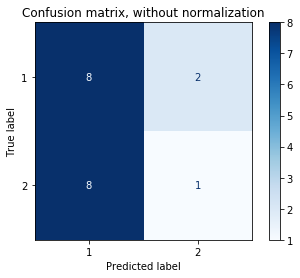

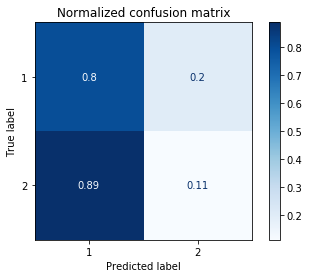

In [16]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

### PCA on temporal

In [17]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'temporal',labels)
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.61 0.26]


### KNN with these PCAs

Confusion matrix, without normalization
[[6 4]
 [8 1]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.89 0.11]]
Accuracy: 0.3684210526315789
Classification score 0.4933333333333333 (pvalue : 0.5445544554455446)
Confusion matrices: [[0.6  0.4 ]
 [0.89 0.11]]


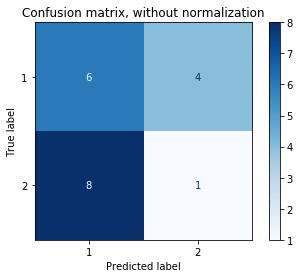

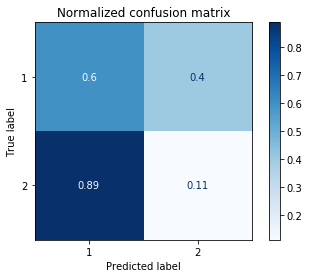

In [18]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

### PCA on occipital

In [19]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'occipital',labels)
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.83 0.11]


### KNN with these PCAs

Confusion matrix, without normalization
[[7 3]
 [7 2]]
Normalized confusion matrix
[[0.7  0.3 ]
 [0.78 0.22]]
Accuracy: 0.47368421052631576
Classification score 0.4533333333333333 (pvalue : 0.8613861386138614)
Confusion matrices: [[0.7  0.3 ]
 [0.78 0.22]]


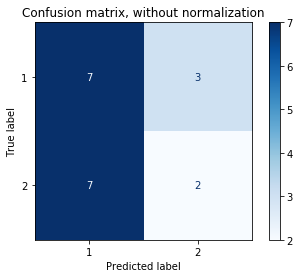

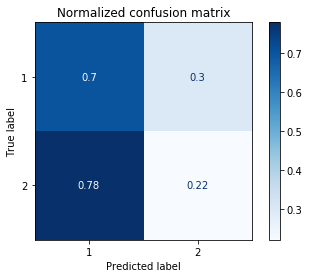

In [20]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

### PCA on frontal

In [21]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'occipital',labels)
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.83 0.11]


### KNN with these PCAs

Confusion matrix, without normalization
[[7 3]
 [7 2]]
Normalized confusion matrix
[[0.7  0.3 ]
 [0.78 0.22]]
Accuracy: 0.47368421052631576
Classification score 0.4533333333333333 (pvalue : 0.8613861386138614)
Confusion matrices: [[0.7  0.3 ]
 [0.78 0.22]]


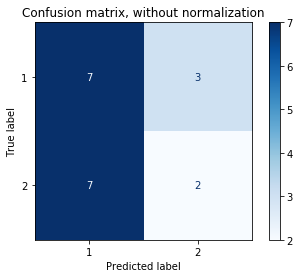

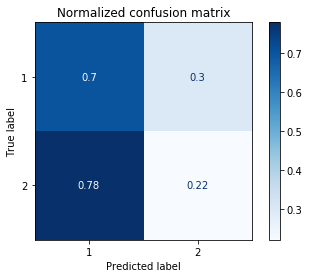

In [22]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

### PCA on parietal

In [23]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'parietal',labels)
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.79 0.16]


### KNN with these PCAs

Confusion matrix, without normalization
[[10  0]
 [ 9  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]
Accuracy: 0.5263157894736842
Classification score 0.4 (pvalue : 0.9405940594059405)
Confusion matrices: [[1. 0.]
 [1. 0.]]


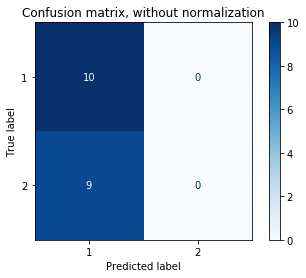

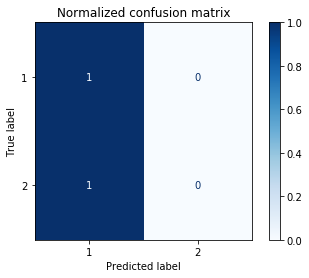

In [24]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

# Comparisons KNN without PCA

## Central

In [25]:
eeg_transp = pre.pca_features_df(df, 'central')

### Knn on pools without Pcas

Confusion matrix, without normalization
[[9 1]
 [8 1]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.89 0.11]]
Accuracy: 0.5263157894736842
Classification score 0.5333333333333333 (pvalue : 0.3069306930693069)
Confusion matrices: [[0.9  0.1 ]
 [0.89 0.11]]


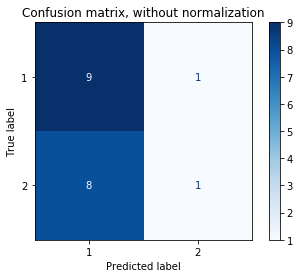

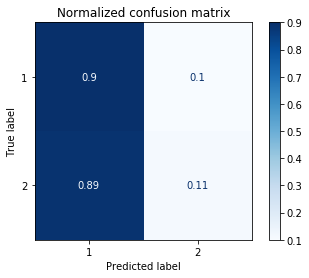

In [26]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(eeg_transp, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

## Temporal

In [27]:
eeg_transp = pre.pca_features_df(df, 'temporal')

Confusion matrix, without normalization
[[6 4]
 [7 2]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.78 0.22]]
Accuracy: 0.42105263157894735
Classification score 0.5599999999999999 (pvalue : 0.15841584158415842)
Confusion matrices: [[0.6  0.4 ]
 [0.78 0.22]]


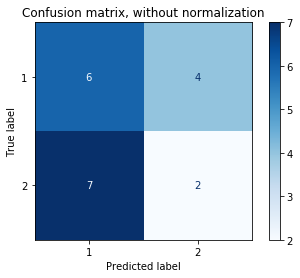

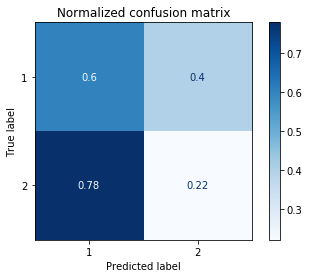

In [28]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(eeg_transp, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

## Frontal

In [29]:
eeg_transp = pre.pca_features_df(df, 'frontal')

Confusion matrix, without normalization
[[4 6]
 [8 1]]
Normalized confusion matrix
[[0.4  0.6 ]
 [0.89 0.11]]
Accuracy: 0.2631578947368421
Classification score 0.44000000000000006 (pvalue : 0.8910891089108911)
Confusion matrices: [[0.4  0.6 ]
 [0.89 0.11]]


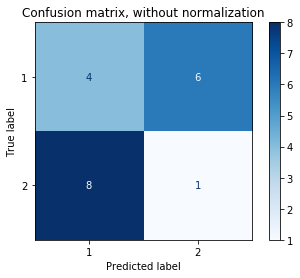

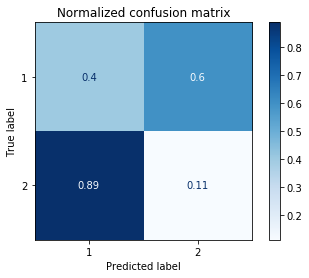

In [30]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(eeg_transp, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

## Parietal

In [31]:
eeg_transp = pre.pca_features_df(df, 'parietal')

Confusion matrix, without normalization
[[5 5]
 [7 2]]
Normalized confusion matrix
[[0.5  0.5 ]
 [0.78 0.22]]
Accuracy: 0.3684210526315789
Classification score 0.5333333333333333 (pvalue : 0.39603960396039606)
Confusion matrices: [[0.5  0.5 ]
 [0.78 0.22]]


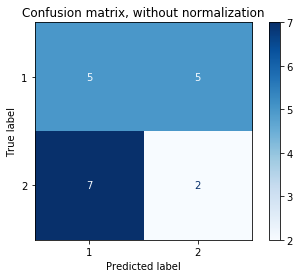

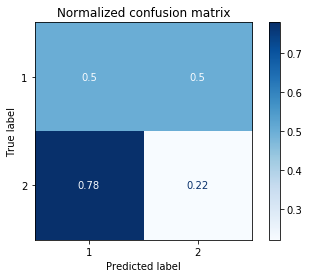

In [32]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(eeg_transp, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

## Occipital

In [33]:
eeg_transp = pre.pca_features_df(df, 'occipital')

Confusion matrix, without normalization
[[6 4]
 [5 4]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.56 0.44]]
Accuracy: 0.5263157894736842
Classification score 0.49333333333333335 (pvalue : 0.6237623762376238)
Confusion matrices: [[0.6  0.4 ]
 [0.56 0.44]]


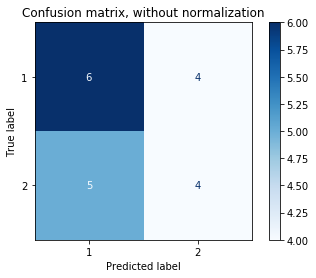

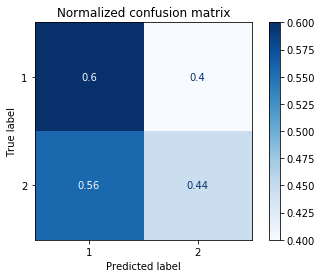

In [34]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(eeg_transp, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

# PCA on conners data

In [35]:
le = preprocessing.LabelEncoder()#encode features with scitkit learn encoder
conners_knn = neuro
features = neuro
conners_knn['subtype'] = le.fit_transform(conners_knn['subtype'])# encoding series with categorical variables
conners_knn = conners_knn[["cIM", 'cHR', 'cIE', "cSC", 'subtype']].copy()
labels = conners_knn['subtype']
features = features[["cIM", 'cHR', 'cIE', "cSC"]].copy()# features

In [36]:
principalDf, fig, pca_exp_var = pre.pca_package_noteeg(features,labels, 'subtype')
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.49 0.28]


### KNN with these PCAs

Confusion matrix, without normalization
[[10  0]
 [ 5  4]]
Normalized confusion matrix
[[1.   0.  ]
 [0.56 0.44]]
Accuracy: 0.7368421052631579
Classification score 0.6933333333333332 (pvalue : 0.009900990099009901)
Confusion matrices: [[1.   0.  ]
 [0.56 0.44]]


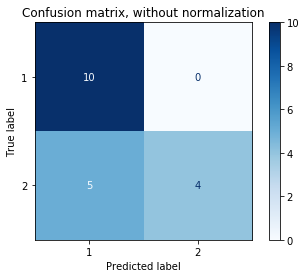

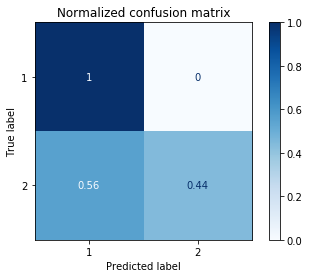

In [37]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

# PCA on behavioral data

In [38]:
le = preprocessing.LabelEncoder()# encoding series with categorical variables
neuro_knn = neuro
features = neuro
neuro_knn['subtype'] = le.fit_transform(neuro_knn['subtype'])# encoding series with categorical variables
neuro_knn = neuro_knn[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis', 'subtype']]
labels = neuro_knn['subtype']
features = features[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis']].copy()# features

In [39]:
principalDf, fig, pca_exp_var = pre.pca_package_noteeg(features,labels, 'subtype')
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.63 0.25]


### KNN with these PCAs

Confusion matrix, without normalization
[[8 2]
 [7 2]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.78 0.22]]
Accuracy: 0.5263157894736842
Classification score 0.4800000000000001 (pvalue : 0.6732673267326733)
Confusion matrices: [[0.8  0.2 ]
 [0.78 0.22]]


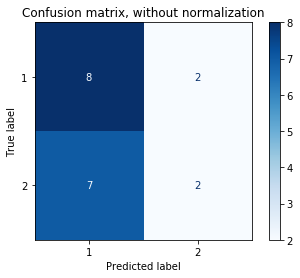

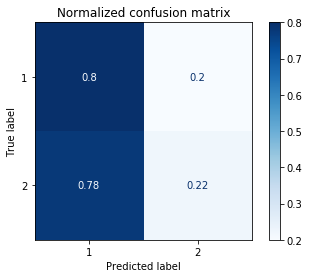

In [40]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

# KNN with Conners data without PCA

Preparing data by separating features and labels

In [41]:
le = preprocessing.LabelEncoder()#encode features with scitkit learn encoder
conners_knn = neuro
features = neuro
conners_knn['subtype'] = le.fit_transform(conners_knn['subtype'])# encoding series with categorical variables
conners_knn = conners_knn[["cIM", 'cHR', 'cIE', "cSC", 'subtype']].copy()
labels = conners_knn['subtype']
features = features[["cIM", 'cHR', 'cIE', "cSC"]].copy()# features

### KNN without PCAs

Confusion matrix, without normalization
[[9 1]
 [4 5]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.44 0.56]]
Accuracy: 0.7368421052631579
Classification score 0.6666666666666667 (pvalue : 0.019801980198019802)
Confusion matrices: [[0.9  0.1 ]
 [0.44 0.56]]


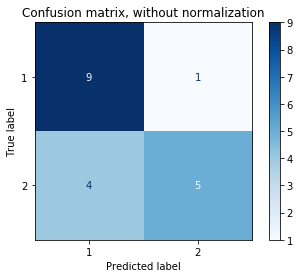

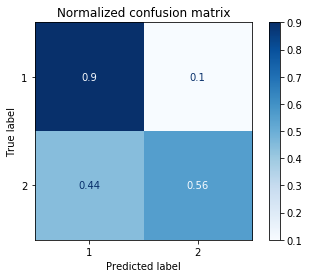

In [42]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(features, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

# KNN on behavioral data without PCA

In [43]:
le = preprocessing.LabelEncoder()
# encoding series with categorical variables
neuro_knn = neuro
features = neuro
neuro_knn['subtype'] = le.fit_transform(neuro_knn['subtype'])
neuro_knn = neuro_knn[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis', 'subtype']]
# features
features = features[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis']].copy()

### KNN without PCAs

Confusion matrix, without normalization
[[9 1]
 [8 1]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.89 0.11]]
Accuracy: 0.5263157894736842
Classification score 0.4533333333333334 (pvalue : 0.7623762376237624)
Confusion matrices: [[0.9  0.1 ]
 [0.89 0.11]]


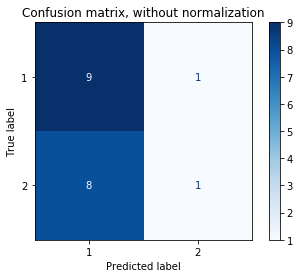

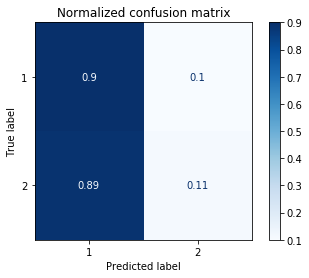

In [44]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(features, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

# EEG KNN trying to predict  sex

In [45]:
le = preprocessing.LabelEncoder()#encode features with scitkit learn encoder
features = df_sex
features = features[['electrode', 'brain_oscillation', 'fft_abs_power', 'inat', 'hyper']].copy()# encoding series with categorical variables
features['electrode'] = le.fit_transform(features['electrode'])
features['brain_oscillation'] = le.fit_transform(features['brain_oscillation'])
sex_labels
# eeg_dataset= pd.concat([features,sex_labels], axis=1).rename(columns={0: "labels"}).reset_index(drop=True)
# sex_labels = eeg_dataset['Sex']

12691    1
12714    1
12715    1
12716    1
12717    1
        ..
1267     1
1268     1
1269     1
1262     1
1366     1
Name: Sex, Length: 14288, dtype: int64

### PCAs

In [46]:
principalDf, fig, pca_exp_var = pre.pca_package_noteeg(features,sex_labels,'Sex')
fig.show()
print("explained variance:",pca_exp_var)

explained variance: [0.57 0.18]


### KNN with these PCAs

Confusion matrix, without normalization
[[1649   72]
 [ 302  835]]
Normalized confusion matrix
[[0.96 0.04]
 [0.27 0.73]]
Accuracy: 0.8691392582225332
Classification score 0.858267716535433 (pvalue : 0.009900990099009901)
Confusion matrices: [[0.96 0.04]
 [0.27 0.73]]


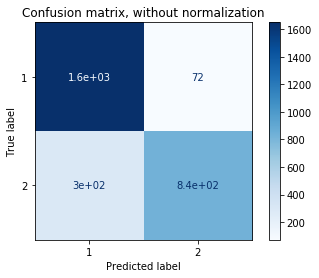

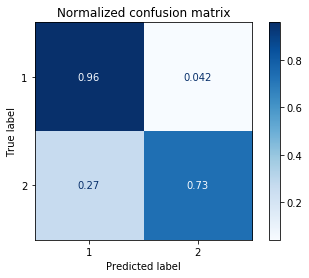

In [47]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing(principalDf, sex_labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()

### KNN without PCAS

Confusion matrix, without normalization
[[1649   72]
 [ 394  743]]
Normalized confusion matrix
[[0.96 0.04]
 [0.35 0.65]]
Accuracy: 0.8369489153254024
Classification score 0.8364829396325459 (pvalue : 0.009900990099009901)
Confusion matrices: [[0.96 0.04]
 [0.35 0.65]]


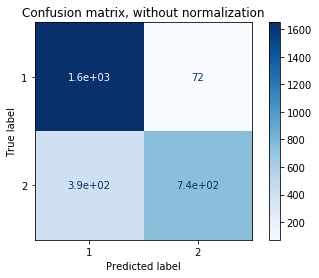

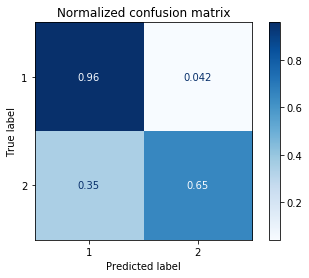

In [48]:
accuracy, score, pvalue, confusion_matrix, fig_matrix = pre.knn_testing_nopca(features, sex_labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)
fig_matrix.show()